In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import glob

from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

from agentfil import plot_utils

import copy

In [3]:
purples = mpl.colormaps['Purples']
blues = mpl.colormaps['Blues']
greens = mpl.colormaps['Greens']
oranges = mpl.colormaps['Oranges']
reds = mpl.colormaps['Reds']

In [38]:
colors = [purples, blues, greens, oranges, reds]

results_root_dir=os.path.join(os.environ['HOME'],'agentfil','power_concentration')

rbp=6
rr=0.6
fpr=0.6
dur=360

exp_str_template = 'DCAPowerConcentration=%s-ConstFilSupplyDiscountRate=%d-MaxDailyOnboard=%0.02f-RenewalRate=%0.02f-FilPlusRate=%0.02f-SectorDuration=%d'

concentrations = [
#     '2,2,2,1,1,',
    '4,1,1,1,1',
    '5,4,3,2,1'
]
fil_supply_discount_rates = [10]

experiment_dirs = []
experiment_names = []
macro_plt_kwargs_list = []
ii = 0
for concentration in concentrations:
    for dr in fil_supply_discount_rates:
        exp_str = exp_str_template % (concentration, dr, rbp, rr, fpr, dur)
        experiment_dirs.append(exp_str)
#         experiment_names.append('%d-%s' % (dr, concentration))
        experiment_names.append('%s' % (concentration,))
        macro_plt_kwargs_list.append({
            'color': colors[ii](0.5)
        })
        ii += 1

baseline_dir = exp_str_template % ('1,1,1,1,1', dr, rbp, rr, fpr, dur)
        
# baseline_fpr = 0.8
# baseline_sector_duration = 360
# baseline_folder = os.path.join(os.environ['HOME'],'agentfil','baseline')
# baseline_experiment = 'BaselineDCA_RBP_%0.02f-RR_%0.02f-FPR_%0.02f-Dur_%0.02f' % \
#                 (6, 0.6, baseline_fpr, baseline_sector_duration)
# baseline_filecoin_df = pd.read_csv(os.path.join(baseline_folder, baseline_experiment, 'filecoin_df.csv'))


# plot settings
min_agent_plot_date = date(2023, 4, 1)
max_agent_plot_date = date(2026, 12, 31)

min_kpi_plot_date = None
max_kpi_plot_date = date(2026, 12, 31)

save_dir = os.path.join('/Users/kiran/Documents/chainscience')
os.makedirs(save_dir,exist_ok=True)

In [39]:
experiment_dirs

['DCAPowerConcentration=4,1,1,1,1-ConstFilSupplyDiscountRate=10-MaxDailyOnboard=6.00-RenewalRate=0.60-FilPlusRate=0.60-SectorDuration=360',
 'DCAPowerConcentration=5,4,3,2,1-ConstFilSupplyDiscountRate=10-MaxDailyOnboard=6.00-RenewalRate=0.60-FilPlusRate=0.60-SectorDuration=360']

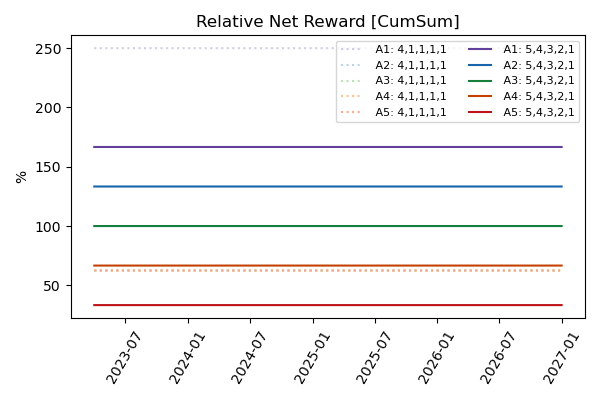

In [40]:
plt.figure(figsize=(6,4))

num_exp=2
cav = np.linspace(0.3, 0.8, num_exp)

plt_kwargs_list = [
    [{'color': purples(cav[0]), 'linestyle':':'}, {'color': blues(cav[0]), 'linestyle':':'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1])}, {'color': blues(cav[1])}, {'color': greens(cav[1])}, {'color': oranges(cav[1])}, {'color': reds(cav[1])}],
]
per_agent_label_list = ['A1:', 'A2:', 'A3:', 'A4:', 'A5:']


# plt.subplot(1,2,1)
def compute_net_reward_FIL(key_data):
    net_reward_FIL = key_data['reward_FIL'].cumsum() - key_data['pledge_interest_payment_FIL'].cumsum()
    return net_reward_FIL/1_000_000

def get_baseline_reward_FIL(idd=0, exp_dir=baseline_dir):
    agent2agentinfo, agent2accountinginfo = plot_utils.get_agent_dfs(results_root_dir, exp_dir)
    # we only use the first agent, since they should all have the same results
    baseline_df = agent2accountinginfo[idd]
    baseline_df = baseline_df[pd.to_datetime(baseline_df['date']) >= pd.to_datetime(min_agent_plot_date)]
    baseline_df = baseline_df[pd.to_datetime(baseline_df['date']) <= pd.to_datetime(max_agent_plot_date)]
    baseline_net_reward = compute_net_reward_FIL(baseline_df)
    return baseline_net_reward, baseline_df['date']

baseline_reward_FIL, baseline_t = get_baseline_reward_FIL()
def reward_ratio_baseline_FIL(key_data):
    rew = compute_net_reward_FIL(key_data)
    rew_scaled = rew / baseline_reward_FIL * 100
    return rew_scaled

def reward_minus_baseline_FIL(key_data, baseline_id=0, exp_dir=baseline_dir):
    rew = compute_net_reward_FIL(key_data)
    baseline_reward_FIL, _ = get_baseline_reward_FIL(idd=baseline_id, exp_dir=exp_dir)
    rew_scaled = rew - baseline_reward_FIL
    return rew_scaled

def reward_ratio_baseline_FIL(key_data, baseline_id=0, exp_dir=baseline_dir):
    rew = compute_net_reward_FIL(key_data)
    baseline_reward_FIL, _ = get_baseline_reward_FIL(idd=baseline_id, exp_dir=exp_dir)
    rew_scaled = rew / baseline_reward_FIL
    return rew_scaled * 100

for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    agent_ids_to_plot = None # plot all
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
           x_post_process=plot_utils.x_post_fn,
           y_post_process=reward_ratio_baseline_FIL, 
            agent_ids_to_plot = agent_ids_to_plot,
           df_name='accounting_df', 
           label_postpend=exp_name, 
           per_agent_label_list=per_agent_label_list,
           plot_kwargs_list=plt_kwargs_list[ii],
           min_date = min_agent_plot_date, max_date = max_agent_plot_date,
          )
plt.title('Relative Net Reward [CumSum]')
plt.ylabel('%')
plt.legend(fontsize=8, ncol=2)
# plt.axhline(0, color='k', linestyle=':')
ax = plt.gca()
# ax.yaxis.grid()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reward_concentration.png'))

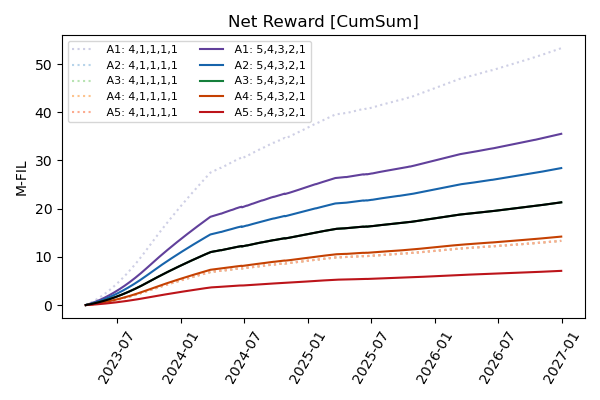

In [41]:
plt.figure(figsize=(6,4))

num_exp=2
cav = np.linspace(0.3, 0.8, num_exp)

plt_kwargs_list = [
    [{'color': purples(cav[0]), 'linestyle':':'}, {'color': blues(cav[0]), 'linestyle':':'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1])}, {'color': blues(cav[1])}, {'color': greens(cav[1])}, {'color': oranges(cav[1])}, {'color': reds(cav[1])}],
]
per_agent_label_list = ['A1:', 'A2:', 'A3:', 'A4:', 'A5:']

for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    agent_ids_to_plot = None # plot all
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
           x_post_process=plot_utils.x_post_fn,
           y_post_process=compute_net_reward_FIL, 
            agent_ids_to_plot = agent_ids_to_plot,
           df_name='accounting_df', 
           label_postpend=exp_name, 
           per_agent_label_list=per_agent_label_list,
           plot_kwargs_list=plt_kwargs_list[ii],
           min_date = min_agent_plot_date, max_date = max_agent_plot_date,
          )
plt.plot(plot_utils.x_post_fn(baseline_t), baseline_reward_FIL, color='k')
    
plt.title('Net Reward [CumSum]')
plt.ylabel('M-FIL')
plt.legend(fontsize=8, ncol=2)
# plt.axhline(0, color='k', linestyle=':')
ax = plt.gca()
# ax.yaxis.grid()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reward_concentration_absolute.png'))

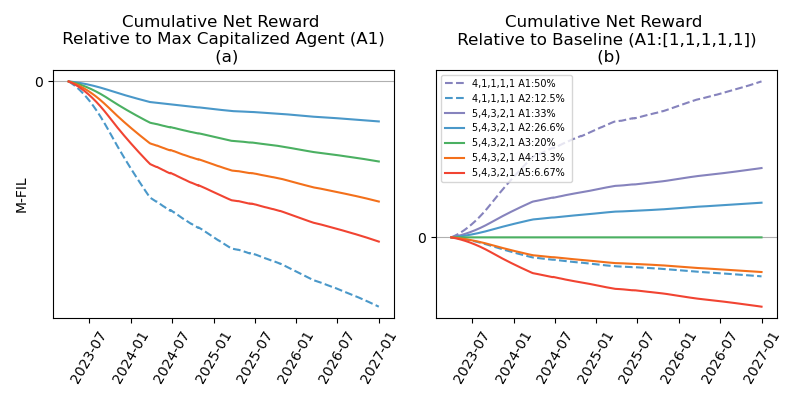

In [45]:
plt.figure(figsize=(8,4))

num_exp=2
cav = np.linspace(0.3, 0.6, num_exp)

plt_kwargs_list = [
    #[{'color': purples(cav[0]), 'linestyle':':'}, {'color': blues(cav[0]), 'linestyle':':'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1]), 'linestyle':'--'}, {'color': blues(cav[1]), 'linestyle':'--'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1])}, {'color': blues(cav[1])}, {'color': greens(cav[1])}, {'color': oranges(cav[1])}, {'color': reds(cav[1])}],
]

plt.subplot(1,2,1)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    # don't plot the first one since that is the baseline
    if exp_name == '4,1,1,1,1':
        agent_ids_to_plot = [1]
        per_agent_label_list = ['A1:50%', 'A2:12.5%', 'A3:12.5%', 'A4:12.5%', 'A5:12.5%']
    elif exp_name == '5,4,3,2,1':
        agent_ids_to_plot = [1,2,3,4]
        per_agent_label_list = ['A1:33%', 'A2:26.6%', 'A3:20%', 'A4:13.3%', 'A5:6.67%']
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
        x_post_process=plot_utils.x_post_fn,
        y_post_process=reward_minus_baseline_FIL, 
        y_post_kwargs={'baseline_id': 0, 'exp_dir':e},
        agent_ids_to_plot=agent_ids_to_plot,
        df_name='accounting_df', 
        label_prepend=exp_name,
        label_postpend='', 
        per_agent_label_list=per_agent_label_list,
        plot_kwargs_list=plt_kwargs_list[ii],
        min_date=min_agent_plot_date, max_date = max_agent_plot_date,
    )
plt.title('Cumulative Net Reward \n Relative to Max Capitalized Agent (A1) \n (a)')
plt.ylabel('M-FIL')
# plt.legend(fontsize=8)
# plt.axhline(0, color='k', linestyle=':')
ax1 = plt.gca()
ax1.yaxis.grid()
ax1.set_yticks([0])
# ax1.set_ylim(-6.5, 2.5)

plt.subplot(1,2,2)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    # don't plot the first one since that is the baseline
    if exp_name == '4,1,1,1,1':
        agent_ids_to_plot = [0,1]
        per_agent_label_list = ['A1:50%', 'A2:12.5%', 'A3:12.5%', 'A4:12.5%', 'A5:12.5%']
    elif exp_name == '5,4,3,2,1':
        agent_ids_to_plot = [0,1,2,3,4]
        per_agent_label_list = ['A1:33%', 'A2:26.6%', 'A3:20%', 'A4:13.3%', 'A5:6.67%']
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
        x_post_process=plot_utils.x_post_fn,
        y_post_process=reward_minus_baseline_FIL, 
        y_post_kwargs={'baseline_id': 0, 'exp_dir':baseline_dir},
        agent_ids_to_plot=agent_ids_to_plot,
        df_name='accounting_df', 
        label_prepend=exp_name,
        label_postpend='', 
        per_agent_label_list=per_agent_label_list,
        plot_kwargs_list=plt_kwargs_list[ii],
        min_date=min_agent_plot_date, max_date = max_agent_plot_date,
    )
# plt.plot(plot_utils.x_post_fn(baseline_t), baseline_reward_FIL, color='k')
    
plt.title('Cumulative Net Reward \n Relative to Baseline (A1:[1,1,1,1,1]) \n (b)')
# plt.ylabel('M-FIL')
plt.legend(fontsize=7)
# plt.axhline(0, color='k', linestyle=':')
ax2 = plt.gca()
ax2.yaxis.grid()
ax2.set_yticks([0])
# ax2.sharey(ax1)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reward_concentration_rbp_%d.png' % (rbp,)))

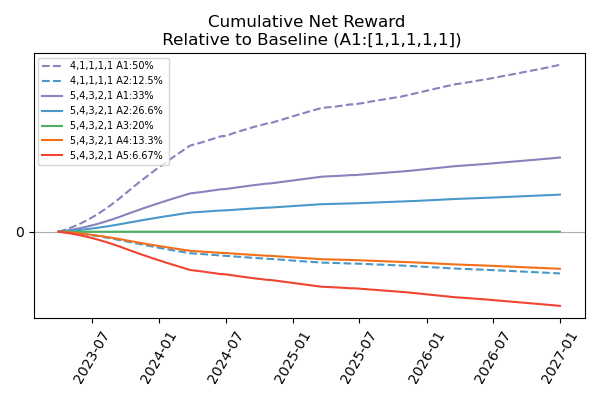

In [49]:
plt.figure(figsize=(6,4))

num_exp=2
cav = np.linspace(0.3, 0.6, num_exp)

plt_kwargs_list = [
    #[{'color': purples(cav[0]), 'linestyle':':'}, {'color': blues(cav[0]), 'linestyle':':'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1]), 'linestyle':'--'}, {'color': blues(cav[1]), 'linestyle':'--'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1])}, {'color': blues(cav[1])}, {'color': greens(cav[1])}, {'color': oranges(cav[1])}, {'color': reds(cav[1])}],
]

# plt.subplot(1,2,2)
for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    # don't plot the first one since that is the baseline
    if exp_name == '4,1,1,1,1':
        agent_ids_to_plot = [0,1]
        per_agent_label_list = ['A1:50%', 'A2:12.5%', 'A3:12.5%', 'A4:12.5%', 'A5:12.5%']
    elif exp_name == '5,4,3,2,1':
        agent_ids_to_plot = [0,1,2,3,4]
        per_agent_label_list = ['A1:33%', 'A2:26.6%', 'A3:20%', 'A4:13.3%', 'A5:6.67%']
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
        x_post_process=plot_utils.x_post_fn,
        y_post_process=reward_minus_baseline_FIL, 
        y_post_kwargs={'baseline_id': 0, 'exp_dir':baseline_dir},
        agent_ids_to_plot=agent_ids_to_plot,
        df_name='accounting_df', 
        label_prepend=exp_name,
        label_postpend='', 
        per_agent_label_list=per_agent_label_list,
        plot_kwargs_list=plt_kwargs_list[ii],
        min_date=min_agent_plot_date, max_date = max_agent_plot_date,
    )
# plt.plot(plot_utils.x_post_fn(baseline_t), baseline_reward_FIL, color='k')
    
plt.title('Cumulative Net Reward \n Relative to Baseline (A1:[1,1,1,1,1])')
# plt.ylabel('M-FIL')
plt.legend(fontsize=7)
# plt.axhline(0, color='k', linestyle=':')
ax2 = plt.gca()
ax2.yaxis.grid()
ax2.set_yticks([0])
# ax2.sharey(ax1)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reward_concentration_rbp_%d.png' % (rbp,)))

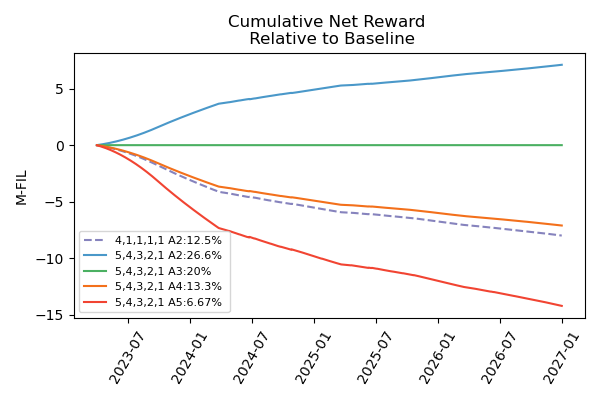

In [43]:
plt.figure(figsize=(6,4))

num_exp=2
cav = np.linspace(0.3, 0.6, num_exp)

plt_kwargs_list = [
    #[{'color': purples(cav[0]), 'linestyle':':'}, {'color': blues(cav[0]), 'linestyle':':'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': blues(cav[0]), 'linestyle':':'}, {'color': purples(cav[1]), 'linestyle':'--'}, {'color': greens(cav[0]), 'linestyle':':'}, {'color': oranges(cav[0]), 'linestyle':':'}, {'color': reds(cav[0]), 'linestyle':':'}],
    [{'color': purples(cav[1])}, {'color': blues(cav[1])}, {'color': greens(cav[1])}, {'color': oranges(cav[1])}, {'color': reds(cav[1])}],
]

for ii, e in enumerate(experiment_dirs):
    exp_name = experiment_names[ii]
    # don't plot the first one since that is the baseline
    if exp_name == '4,1,1,1,1':
        agent_ids_to_plot = [1]
        per_agent_label_list = ['A1:50%', 'A2:12.5%', 'A3:12.5%', 'A4:12.5%', 'A5:12.5%']
    elif exp_name == '5,4,3,2,1':
        agent_ids_to_plot = [1,2,3,4]
        per_agent_label_list = ['A1:33%', 'A2:26.6%', 'A3:20%', 'A4:13.3%', 'A5:6.67%']
    plot_utils.plot_agent(
        results_root_dir,
        ['reward_FIL', 'pledge_interest_payment_FIL'], e,
        x_post_process=plot_utils.x_post_fn,
        y_post_process=reward_minus_baseline_FIL, 
        y_post_kwargs={'baseline_id': 0, 'exp_dir':baseline_dir},
        agent_ids_to_plot=agent_ids_to_plot,
        df_name='accounting_df', 
        label_prepend=exp_name,
        label_postpend='', 
        per_agent_label_list=per_agent_label_list,
        plot_kwargs_list=plt_kwargs_list[ii],
        min_date=min_agent_plot_date, max_date = max_agent_plot_date,
    )
# plt.plot(plot_utils.x_post_fn(baseline_t), baseline_reward_FIL, color='k')
    
plt.title('Cumulative Net Reward \n Relative to Baseline')
plt.ylabel('M-FIL')
plt.legend(fontsize=8)
# plt.axhline(0, color='k', linestyle=':')
ax = plt.gca()
# ax.yaxis.grid()

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'reward_concentration_relative_to_max_agent_baseline.png'))

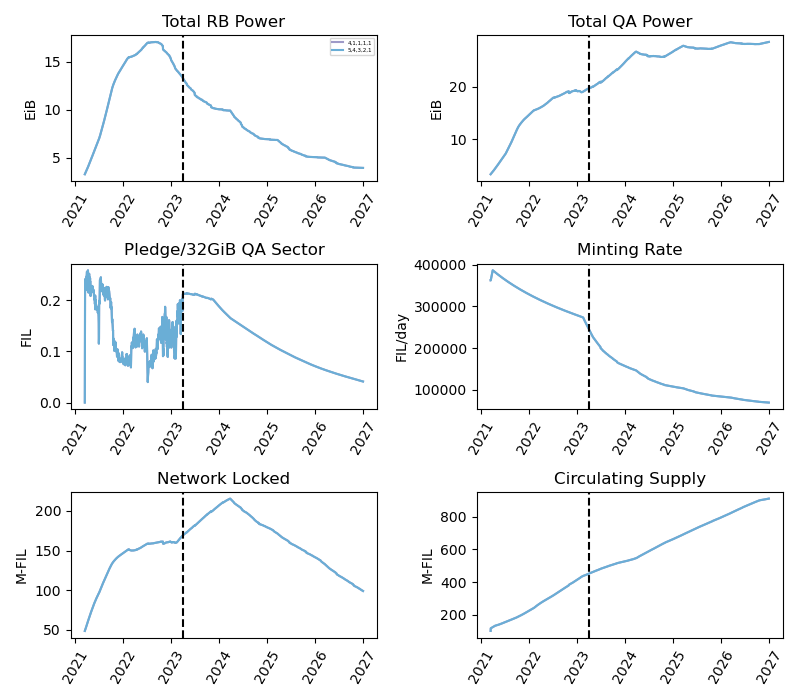

In [44]:
colors = [blues, oranges, greens, purples, reds]

plt_baseline_relative = False
baseline_filecoin_df = None
x_post_fn = plot_utils.x_post_fn

plt.figure(figsize=(8,7))

plt.subplot(3,2,1)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_raw_power_eib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 x_key='date', labels=experiment_names,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total RB Power')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('EiB')
plt.legend(fontsize=4)


plt.subplot(3,2,2)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['total_qa_power_eib'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Total QA Power')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('EiB')


plt.subplot(3,2,3)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_pledge_per_QAP'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Pledge/32GiB QA Sector')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('FIL')

plt.subplot(3,2,4)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['day_network_reward'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=None,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Minting Rate')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('FIL/day')
    

plt.subplot(3,2,5)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['network_locked'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=plot_utils.converttoMFIL,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Network Locked')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('M-FIL')

plt.subplot(3,2,6)
plot_utils.plot_experiments(
    experiment_names, results_root_dir, baseline_filecoin_df,
    ['circ_supply'], experiment_dirs, 
                 x_post_process=x_post_fn, 
                 y_post_process=plot_utils.converttoMFIL,
                 min_date = min_kpi_plot_date, max_date = max_kpi_plot_date,
                 x_key='date', labels=None, plot_kwargs_list=macro_plt_kwargs_list,
                 baseline_relative=plt_baseline_relative)
plt.axvline(date(2023,4,1), linestyle='--', color='k')
plt.title('Circulating Supply')
if plt_baseline_relative:
    plt.ylabel('%')
else:
    plt.ylabel('M-FIL')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'concentration_rbp_%d_kpis.png' % (rbp,)))